Back to the main [Index](../index.ipynb)

### Working with SED-ML

SED-ML describes how to run a set of simulations on a model encoded in SBML or CellML through specifying tasks, algorithm parameters, and post-processing. SED-ML has a limited vocabulary of simulation types (timecourse and steady state) is not designed to replace scripting with Python or other general-purpose languages. Instead, SED-ML is designed to provide a rudimentary way to reproduce the dynamics of a model across different tools. This process would otherwise require human intervention and becomes very laborious when thousands of models are involved.

The basic elements of a SED-ML document are:

* **Models**, which reference external SBML/CellML files or other previously defined models within the same SED-ML document,
* **Simulations**, which reference specific numerical solvers from the [KiSAO ontology](http://co.mbine.org/standards/kisao),
* **Tasks**, which apply a simulation to a model, and
* **Outputs**, which can be plots or reports.

Models in SED-ML essentially create instances of SBML/CellML models, and each instance can have different parameters.

Tellurium's approach to handling SED-ML is to first convert the SED-ML document to a Python script, which contains all the Tellurium-specific function calls to run all tasks described in the SED-ML. For authoring SED-ML, Tellurium uses PhraSEDML, a human-readable analog of SED-ML. Example syntax is shown below.

SED-ML files are not very useful in isolation. Since SED-ML always references external SBML and CellML files, software which supports exchanging SED-ML files should use COMBINE archives, which package all related standards-encoded files together.

> Reproducible computational biology experiments with SED-ML - The Simulation Experiment Description Markup Language. Waltemath D., Adams R., Bergmann F.T., Hucka M., Kolpakov F., Miller A.K., Moraru I.I., Nickerson D., Snoep J.L.,Le Novère, N. BMC Systems Biology 2011, 5:198 (http://www.pubmed.org/22172142)

#### Creating a SED-ML file

This example shows how to use PhraSEDML to author SED-ML files. Whenever a PhraSEDML script references an external model, you should use `phrasedml.setReferencedSBML` to ensure that the PhraSEDML script can be properly converted into a SED-ML file.

In [9]:
from __future__ import print_function
import tellurium as te
te.setDefaultPlottingEngine('matplotlib')
%matplotlib inline
import phrasedml

antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S1 = 10; S2 = 0
  k1 = 1
end
'''

phrasedml_str = '''
  model1 = model "myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  plot "Figure 1" time vs S1, S2
'''

# create the sedml xml string from the phrasedml
sbml_str = te.antimonyToSBML(antimony_str)
phrasedml.setReferencedSBML("myModel", sbml_str)

sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    print(phrasedml.getLastPhrasedError())
print(sedml_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.0.7 with libSBML version 5.15.0. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version2" level="1" version="2">
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfPoints="100">
      <algorithm kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-1" source="myModel"/>
  </listOfModels>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="plot_0_0_0" name="time">
      <listOfVariables>
        <variable id="time" symbol="urn:sedml:symbol:time" taskReference="task1"/>
      </listOfVariables>
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time </ci>
      </math>
    </dataGenerator>
    <dataGenerator id="plot_

### Reading / Executing SED-ML

After converting PhraSEDML to SED-ML, you can call `te.executeSEDML` to use Tellurium to execute all simulations in the SED-ML. This example also shows how to use [libSEDML](https://github.com/fbergmann/libSEDML) (used by Tellurium and PhraSEDML internally) for reading SED-ML files.

SBML file written to /tmp/tmptfluii7w_sedml/myModel
SED-ML file written to /tmp/tmptfluii7w_sedml/sed_main.xml
Read SED-ML file, number of errors: 0


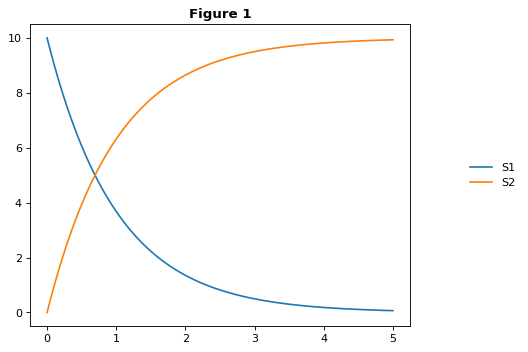

In [10]:
import tempfile, os, shutil

workingDir = tempfile.mkdtemp(suffix="_sedml")

sbml_file = os.path.join(workingDir, 'myModel')
sedml_file = os.path.join(workingDir, 'sed_main.xml')

with open(sbml_file, 'wb') as f:
    f.write(sbml_str.encode('utf-8'))
    f.flush()
    print('SBML written to temporary file')

with open(sedml_file, 'wb') as f:
    f.write(sedml_str.encode('utf-8'))
    f.flush()
    print('SED-ML written to temporary file')

# For technical reasons, any software which uses libSEDML
# must provide a custom build - Tellurium uses tesedml
import tesedml as libsedml
sedml_doc = libsedml.readSedML(sedml_file)
n_errors = sedml_doc.getErrorLog().getNumFailsWithSeverity(libsedml.LIBSEDML_SEV_ERROR)
print('Read SED-ML file, number of errors: {}'.format(n_errors))
if n_errors > 0:
    print(sedml_doc.getErrorLog().toString())

# execute SED-ML using Tellurium
te.executeSEDML(sedml_str, workingDir=workingDir)

# clean up
#shutil.rmtree(workingDir)

### SED-ML L1V2 specification example

This example uses the celebrated [repressilator model](https://www.ebi.ac.uk/biomodels-main/BIOMD0000000012) to demonstrate how to 1) download a model from the [BioModels database](https://www.ebi.ac.uk/biomodels-main/), 2) create a PhraSEDML string to simulate the model, 3) convert the PhraSEDML to SED-ML, and 4) use Tellurium to execute the resulting SED-ML.

This and other examples here are the [SED-ML reference specification](http://sed-ml.sourceforge.net/documents/sed-ml-L1V2.pdf) (Introduction section).

INFO:root:Initialising BioModels service (WSDL)


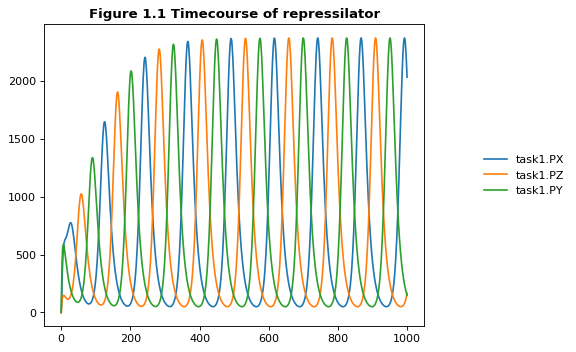

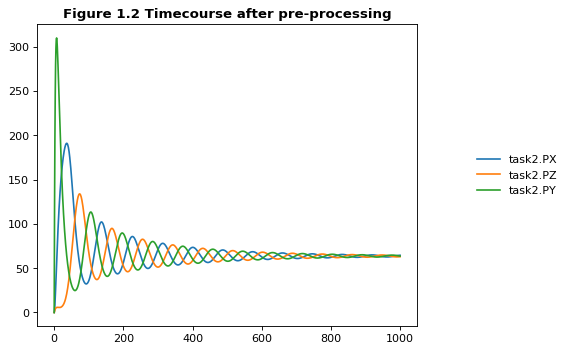

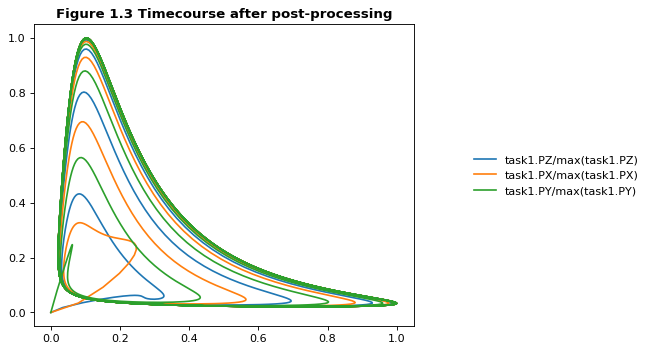

In [11]:
from __future__ import print_function
import tellurium as te, tellurium.temiriam as temiriam
te.setDefaultPlottingEngine('matplotlib')
%matplotlib inline
import phrasedml

# Get SBML from URN and set for phrasedml
urn = "urn:miriam:biomodels.db:BIOMD0000000012"
sbml_str = temiriam.getSBMLFromBiomodelsURN(urn=urn)
phrasedml.setReferencedSBML('BIOMD0000000012', sbml_str)

# <SBML species>
#   PX - LacI protein
#   PY - TetR protein
#   PZ - cI protein
#   X - LacI mRNA
#   Y - TetR mRNA
#   Z - cI mRNA

# <SBML parameters>
#   ps_a - tps_active: Transcrition from free promotor in transcripts per second and promotor
#   ps_0 - tps_repr: Transcrition from fully repressed promotor in transcripts per second and promotor

phrasedml_str = """
    model1 = model "{}"
    model2 = model model1 with ps_0=1.3E-5, ps_a=0.013
    sim1 = simulate uniform(0, 1000, 1000)
    task1 = run sim1 on model1
    task2 = run sim1 on model2

    # A simple timecourse simulation
    plot "Figure 1.1 Timecourse of repressilator" task1.time vs task1.PX, task1.PZ, task1.PY

    # Applying preprocessing
    plot "Figure 1.2 Timecourse after pre-processing" task2.time vs task2.PX, task2.PZ, task2.PY

    # Applying postprocessing
    plot "Figure 1.3 Timecourse after post-processing" task1.PX/max(task1.PX) vs task1.PZ/max(task1.PZ), \
                                                       task1.PY/max(task1.PY) vs task1.PX/max(task1.PX), \
                                                       task1.PZ/max(task1.PZ) vs task1.PY/max(task1.PY)
""".format('BIOMD0000000012')

# convert to SED-ML
sedml_str = phrasedml.convertString(phrasedml_str)
if sedml_str == None:
    raise RuntimeError(phrasedml.getLastError())

# Run the SED-ML file with results written in workingDir
import tempfile, shutil, os
workingDir = tempfile.mkdtemp(suffix="_sedml")
# write out SBML
with open(os.path.join(workingDir, 'BIOMD0000000012'), 'wb') as f:
    f.write(sbml_str.encode('utf-8'))
te.executeSEDML(sedml_str, workingDir=workingDir)
shutil.rmtree(workingDir)